1.Lstm + CNN

d:\Thesis\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 1/3 - Loss: 0.5228 - Train Acc: 0.8122
Epoch 2/3 - Loss: 0.3000 - Train Acc: 0.8966
Epoch 3/3 - Loss: 0.2396 - Train Acc: 0.9162

📈 Final Test Metrics:
 Accuracy       : 0.9283
 Precision      : 0.9352
 Recall         : 0.9283
 F1 Score       : 0.9296
 Mean Abs Error : 0.0959
 MCC            : 0.9116
 R² Score       : 0.9250


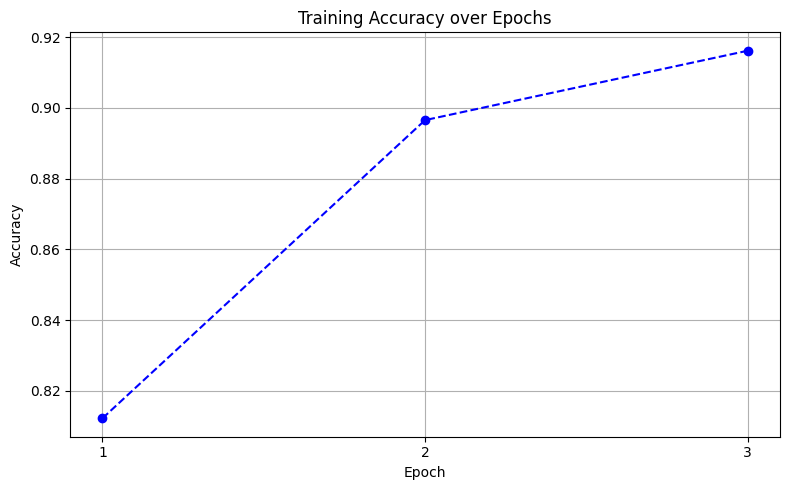

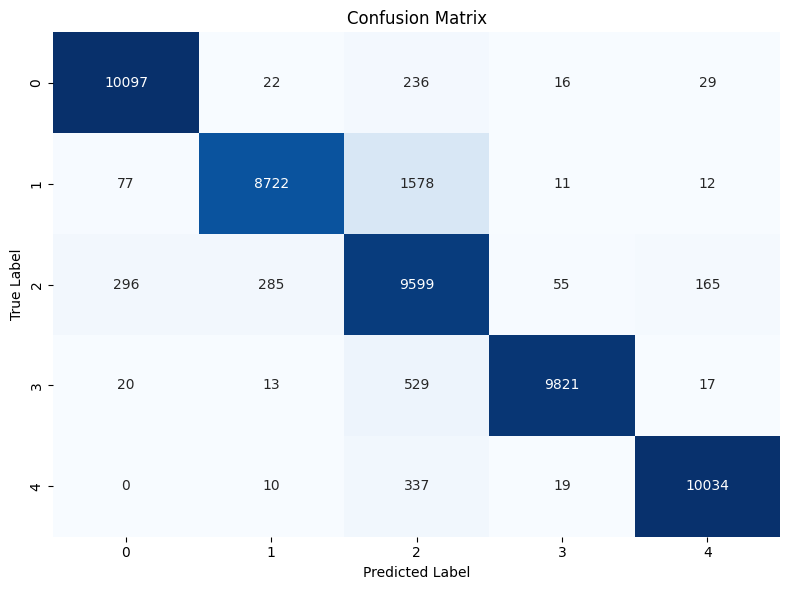

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, matthews_corrcoef, r2_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import random


DEVICE     = torch.device("cuda")
PRETRAINED = 'prajjwal1/bert-tiny'
MAX_LEN    = 128
BATCH      = 32
EPOCHS     = 3
LR         = 2e-5
DATA_PATH  = r'D:\Thesis\16-7-25\thesis 2.csv'


df = pd.read_csv(DATA_PATH)
texts  = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)


class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]
        enc   = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


tokenizer    = AutoTokenizer.from_pretrained(PRETRAINED)
train_ds     = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
test_ds      = SentimentDataset(X_test,  y_test,  tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH)


class LSTMCNNClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        H = bert_model.config.hidden_size
        self.lstm = nn.LSTM(H, 128, batch_first=True, bidirectional=True)
        self.conv = nn.Conv1d(256, 100, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.drop = nn.Dropout(0.3)
        self.classifier = nn.Linear(100, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = out.last_hidden_state                        
        x, _ = self.lstm(x)                              
        x = x.permute(0, 2, 1)                           
        x = self.conv(x)                                 
        x = self.pool(x).squeeze(-1)                     
        x = self.drop(x)
        return self.classifier(x)


bert_model = AutoModel.from_pretrained(PRETRAINED)
model      = LSTMCNNClassifier(bert_model, num_classes=len(set(labels))).to(DEVICE)
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.AdamW(model.parameters(), lr=LR)


train_accuracies = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)
        optimizer.zero_grad()
        logits = model(ids, mask)
        loss   = criterion(logits, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    train_acc = correct / total
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f}")


model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)
        logits = model(ids, mask)
        preds  = logits.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(lbls.cpu().numpy())


acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec  = recall_score(y_true, y_pred, average='macro')
f1   = f1_score(y_true, y_pred, average='macro')
mae  = mean_absolute_error(y_true, y_pred)
mcc  = matthews_corrcoef(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print("\n📈 Final Test Metrics:")
print(f" Accuracy       : {acc:.4f}")
print(f" Precision      : {prec:.4f}")
print(f" Recall         : {rec:.4f}")
print(f" F1 Score       : {f1:.4f}")
print(f" Mean Abs Error : {mae:.4f}")
print(f" MCC            : {mcc:.4f}")
print(f" R² Score       : {r2:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_accuracies, marker='o', linestyle='--', color='b')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, EPOCHS + 1))
plt.grid(True)
plt.tight_layout()
plt.show()


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


2.Lstm + BiLstm

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, matthews_corrcoef, r2_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED = 'prajjwal1/bert-tiny'
MAX_LEN    = 128
BATCH      = 32
EPOCHS     = 3
LR         = 2e-5
DATA_PATH  = r'D:\Thesis\16-7-25\thesis 2.csv'


df = pd.read_csv(DATA_PATH)
texts  = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)


class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]
        enc   = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer    = AutoTokenizer.from_pretrained(PRETRAINED)
train_ds     = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
test_ds      = SentimentDataset(X_test,  y_test,  tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH)


class LSTM_BiLSTMClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        H = bert_model.config.hidden_size
        self.lstm1 = nn.LSTM(H, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.pool  = nn.AdaptiveMaxPool1d(1)
        self.drop  = nn.Dropout(0.3)
        self.classifier = nn.Linear(128, num_classes)  

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = out.last_hidden_state                        
        x, _ = self.lstm1(x)                             
        x, _ = self.lstm2(x)                             
        x = x.permute(0, 2, 1)                           
        x = self.pool(x).squeeze(-1)                     
        x = self.drop(x)
        return self.classifier(x)

bert_model = AutoModel.from_pretrained(PRETRAINED)
model      = LSTM_BiLSTMClassifier(bert_model, num_classes=len(set(labels))).to(DEVICE)
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.AdamW(model.parameters(), lr=LR)

train_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)
        optimizer.zero_grad()
        logits = model(ids, mask)
        loss   = criterion(logits, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    train_acc = correct / total
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f}")

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)
        logits = model(ids, mask)
        preds  = logits.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(lbls.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec  = recall_score(y_true, y_pred, average='macro')
f1   = f1_score(y_true, y_pred, average='macro')
mae  = mean_absolute_error(y_true, y_pred)
mcc  = matthews_corrcoef(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print("\n📈 Final Test Metrics:")
print(f" Accuracy       : {acc:.4f}")
print(f" Precision      : {prec:.4f}")
print(f" Recall         : {rec:.4f}")
print(f" F1 Score       : {f1:.4f}")
print(f" Mean Abs Error : {mae:.4f}")
print(f" MCC            : {mcc:.4f}")
print(f" R² Score       : {r2:.4f}")

def plot_accuracy_curve(train_accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, marker='o')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('accuracy_curve.png')
    plt.close()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()

plot_accuracy_curve(train_accuracies)
plot_confusion_matrix(y_true, y_pred)


Epoch 1/3 - Loss: 0.6037 - Train Acc: 0.7921
Epoch 2/3 - Loss: 0.3361 - Train Acc: 0.8880
Epoch 3/3 - Loss: 0.2787 - Train Acc: 0.9059

📈 Final Test Metrics:
 Accuracy       : 0.9178
 Precision      : 0.9276
 Recall         : 0.9178
 F1 Score       : 0.9195
 Mean Abs Error : 0.1106
 MCC            : 0.8991
 R² Score       : 0.9134


3.BiLSTM + Self-Attention

Epoch 1/3 - Loss: 0.5345 - Train Acc: 0.8089
Epoch 2/3 - Loss: 0.3087 - Train Acc: 0.8942
Epoch 3/3 - Loss: 0.2437 - Train Acc: 0.9145

📈 Final Test Metrics:
 Accuracy       : 0.9282
 Precision      : 0.9330
 Recall         : 0.9282
 F1 Score       : 0.9294
 Mean Abs Error : 0.0943
 MCC            : 0.9109
 R² Score       : 0.9281


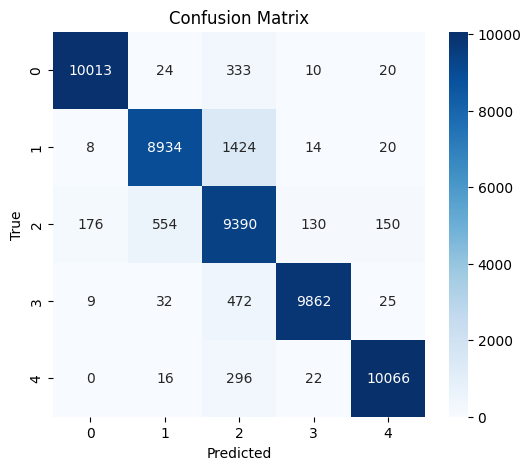

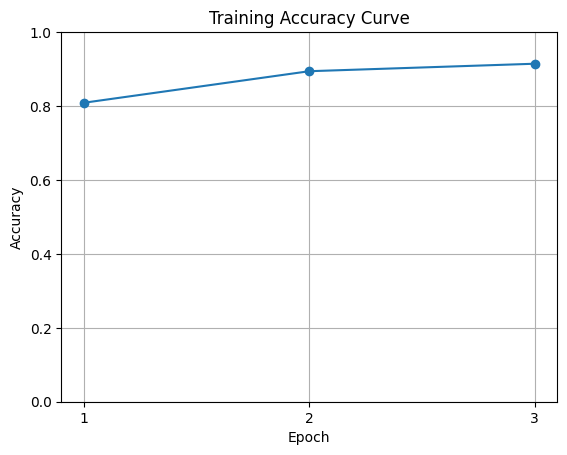

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, matthews_corrcoef, r2_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED = 'prajjwal1/bert-tiny'
MAX_LEN    = 128
BATCH      = 32
EPOCHS     = 3
LR         = 2e-5
DATA_PATH  = r'D:\Thesis\16-7-25\thesis 2.csv'

df = pd.read_csv(DATA_PATH)
texts  = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]
        enc   = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer    = AutoTokenizer.from_pretrained(PRETRAINED)
train_ds     = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
test_ds      = SentimentDataset(X_test,  y_test,  tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH)

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
    def forward(self, lstm_output):
        weights = self.attn(lstm_output).squeeze(-1)
        weights = torch.softmax(weights, dim=1)
        context = torch.bmm(weights.unsqueeze(1), lstm_output)
        return context.squeeze(1)

class SABLSTMClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        H = bert_model.config.hidden_size
        self.bilstm = nn.LSTM(H, 128, batch_first=True, bidirectional=True)
        self.attn   = SelfAttention(256)
        self.drop   = nn.Dropout(0.3)
        self.classifier = nn.Linear(256, num_classes)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = out.last_hidden_state
        x, _ = self.bilstm(x)
        x = self.attn(x)
        x = self.drop(x)
        return self.classifier(x)

bert_model = AutoModel.from_pretrained(PRETRAINED)
model      = SABLSTMClassifier(bert_model, num_classes=len(set(labels))).to(DEVICE)
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.AdamW(model.parameters(), lr=LR)

train_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)

        optimizer.zero_grad()
        logits = model(ids, mask)
        loss   = criterion(logits, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)

    train_acc = correct / total
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f}")

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)
        logits = model(ids, mask)
        preds  = logits.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(lbls.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec  = recall_score(y_true, y_pred, average='macro')
f1   = f1_score(y_true, y_pred, average='macro')
mae  = mean_absolute_error(y_true, y_pred)
mcc  = matthews_corrcoef(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print("\n📈 Final Test Metrics:")
print(f" Accuracy       : {acc:.4f}")
print(f" Precision      : {prec:.4f}")
print(f" Recall         : {rec:.4f}")
print(f" F1 Score       : {f1:.4f}")
print(f" Mean Abs Error : {mae:.4f}")
print(f" MCC            : {mcc:.4f}")
print(f" R² Score       : {r2:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(set(labels)),
            yticklabels=sorted(set(labels)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


plt.plot(range(1, len(train_accuracies)+1), train_accuracies, marker='o')
plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(train_accuracies)+1))
plt.ylim(0, 1)
plt.grid(True)
plt.show()


4.BERTLex-CNN

Epoch 1/3 - Loss: 0.5308 - Train Acc: 0.8090
Epoch 2/3 - Loss: 0.3044 - Train Acc: 0.8962
Epoch 3/3 - Loss: 0.2445 - Train Acc: 0.9153

Final Test Metrics:
 Accuracy       : 0.9286
 Precision      : 0.9325
 Recall         : 0.9286
 F1 Score       : 0.9295
 Mean Abs Error : 0.0948
 MCC            : 0.9113
 R² Score       : 0.9270


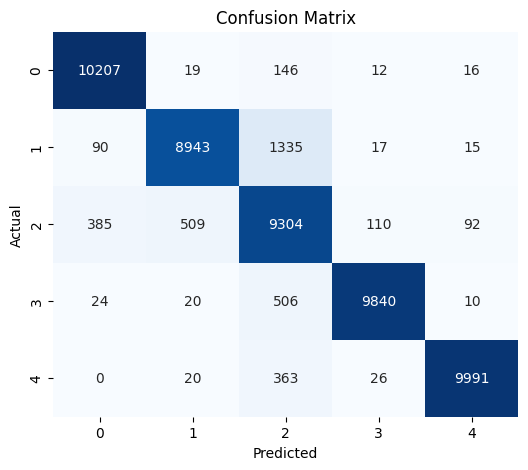

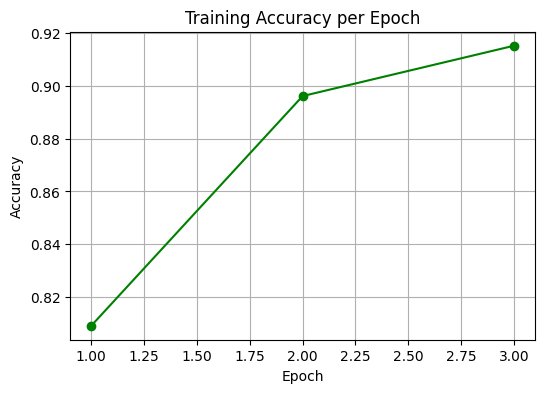

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, matthews_corrcoef, r2_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED = 'prajjwal1/bert-tiny'
MAX_LEN    = 128
BATCH      = 32
EPOCHS     = 3
LR         = 2e-5
DATA_PATH  = r'D:\Thesis\16-7-25\thesis 2.csv'

df = pd.read_csv(DATA_PATH)
X  = df['Text'].astype(str).tolist()
y  = df['Label'].astype(int).tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]
        enc   = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer    = AutoTokenizer.from_pretrained(PRETRAINED)
train_ds     = SentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
test_ds      = SentimentDataset(X_test,  y_test,  tokenizer, MAX_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH)

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
    def forward(self, lstm_output):
        weights = self.attn(lstm_output).squeeze(-1)
        weights = torch.softmax(weights, dim=1)
        context = torch.bmm(weights.unsqueeze(1), lstm_output)
        return context.squeeze(1)

class SABLSTMClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        H = bert_model.config.hidden_size
        self.bilstm = nn.LSTM(H, 128, batch_first=True, bidirectional=True)
        self.attn   = SelfAttention(256)
        self.drop   = nn.Dropout(0.3)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = out.last_hidden_state
        x, _ = self.bilstm(x)
        x = self.attn(x)
        x = self.drop(x)
        return self.classifier(x)

bert_model = AutoModel.from_pretrained(PRETRAINED)
model      = SABLSTMClassifier(bert_model, num_classes=len(set(y))).to(DEVICE)
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.AdamW(model.parameters(), lr=LR)

train_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)

        optimizer.zero_grad()
        logits = model(ids, mask)
        loss   = criterion(logits, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)

    acc = correct / total
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {acc:.4f}")

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        ids   = batch['input_ids'].to(DEVICE)
        mask  = batch['attention_mask'].to(DEVICE)
        lbls  = batch['label'].to(DEVICE)

        logits = model(ids, mask)
        preds  = logits.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(lbls.cpu().numpy())

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec  = recall_score(y_true, y_pred, average='macro')
f1   = f1_score(y_true, y_pred, average='macro')
mae  = mean_absolute_error(y_true, y_pred)
mcc  = matthews_corrcoef(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print("\nFinal Test Metrics:")
print(f" Accuracy       : {acc:.4f}")
print(f" Precision      : {prec:.4f}")
print(f" Recall         : {rec:.4f}")
print(f" F1 Score       : {f1:.4f}")
print(f" Mean Abs Error : {mae:.4f}")
print(f" MCC            : {mcc:.4f}")
print(f" R\u00b2 Score       : {r2:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS + 1), train_accuracies, marker='o', color='green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
